In [1]:
##### IMPORT LIBRARIES #####

from pymongo import MongoClient
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sb
from matplotlib import style
style.use('bmh')

import re

##### DEFINE CONSTANTS #####

UF_VALUE = 29085.91
USD_VALUE = 717.26

##### LOAD DATA FROM MONGODB AND CONVERT TO DATAFRAME#####

collection = 'sale_apartment_2021-01-15'

# Create connection to MongoDB
client = MongoClient(host='localhost')
# Connect to database
db = client['mercado_libre_data']
# Find collection
col = db[collection]

results = col.find({}, {
    '_id': 0, 
    'id': 1,
    'price': 1, 
    'currency_id': 1, 
    'permalink': 1,
    'location': 1,
    'attributes': 1
})

id_list = []
price_list = []
currency_list = []
permalink_list = []
address_list = []
neighborhood_list = []
comuna_list = []
latitude_list = []
longitude_list = []
bedrooms_list = []
bathrooms_list = []
covered_area_list = []
total_area_list = []

for result in results:
    # id
    property_id = result['id']
    id_list.append(property_id)
    # Price
    price = result['price']
    price_list.append(price)
    # Currency id
    currency = result['currency_id']
    currency_list.append(currency)
    # Permalink
    permalink = result['permalink']
    permalink_list.append(permalink)
    # Address line
    address = result['location']['address_line']
    address_list.append(address)
    # Neighborhood
    neighborhood = result['location']['neighborhood']['name']
    neighborhood_list.append(neighborhood)
    # Comuna
    comuna = result['location']['city']['name']
    comuna_list.append(comuna)
    # Latitude
    latitude = result['location']['latitude']
    latitude_list.append(latitude)
    # Longitude
    longitude = result['location']['longitude']
    longitude_list.append(longitude)
    # Attributes
    attributes = result['attributes']
    for i in range(len(attributes)):
        # Bedrooms
        if attributes[i]['id']=='BEDROOMS':
            bedrooms = attributes[i]['value_name']
            bedrooms_list.append(bedrooms)
        # Bathrooms
        elif attributes[i]['id']=='FULL_BATHROOMS':
            bathrooms = attributes[i]['value_name']
            bathrooms_list.append(bathrooms)
        # Covered area
        elif attributes[i]['id']=='COVERED_AREA':
            covered_area = attributes[i]['value_name'].replace('m²', '')
            covered_area_list.append(covered_area)
        # Total area
        elif attributes[i]['id']=='TOTAL_AREA':
            total_area = attributes[i]['value_name'].replace('m²', '')
            total_area_list.append(total_area)
            break

            
## Create dataframe
df = pd.DataFrame(
    list(zip(id_list, price_list, currency_list, permalink_list, address_list, 
             neighborhood_list, comuna_list, latitude_list, longitude_list, 
             bedrooms_list, bathrooms_list, covered_area_list, total_area_list)), 
    columns=['id', 'price', 'currency', 'permalink', 'address', 
             'neighborhood', 'comuna', 'latitude', 'longitude', 
             'bedrooms', 'bathrooms', 'covered_area_m2', 'total_area_m2']
)

# Some data validation...
for idx, row in df.iterrows():
    if not bool(re.match('\d', df.loc[idx, 'bedrooms'])):
        df.loc[idx, 'bedrooms'] = 0
        
    if not bool(re.match('\d', df.loc[idx, 'bathrooms'])):
        df.loc[idx, 'bathrooms'] = 0
        
    if not bool(re.match('\d+\.?\d*', df.loc[idx, 'covered_area_m2'])):
        df.loc[idx, 'covered_area_m2'] = 0
        
    if not bool(re.match('\d+\.?\d*', df.loc[idx, 'total_area_m2'])):
        df.loc[idx, 'total_area_m2'] = 0

df['bedrooms'] = df['bedrooms'].astype(int)
df['bathrooms'] = df['bathrooms'].astype(int)
df['covered_area_m2'] = df['covered_area_m2'].astype(float)
df['total_area_m2'] = df['total_area_m2'].astype(float)
df['neighborhood'] = df['neighborhood'].apply(lambda x: x.title())

df.head()

,id,price,currency,permalink,address,neighborhood,comuna,latitude,longitude,bedrooms,bathrooms,covered_area_m2,total_area_m2
0,MLC542869177,15000.0,CLF,https://departamento.mercadolibre.cl/MLC-54286...,Luminoso departamento mejor barrio El Golf,Barrio El Golf,Las Condes,-33.412570,-70.598470,0,0,0.0,0.0
1,MLC565280223,5600.0,CLF,https://departamento.mercadolibre.cl/MLC-56528...,AV APOQUINDO / MALAGA,Barrio El Golf,Las Condes,-33.415894,-70.586830,0,0,38.0,38.0
2,MLC541154566,18000.0,CLF,https://departamento.mercadolibre.cl/MLC-54115...,Burgos,Barrio El Golf,Las Condes,-33.417583,-70.587234,0,0,235.0,270.0
3,MLC553667447,5290.0,CLF,https://departamento.mercadolibre.cl/MLC-55366...,PRESIDENTE RIESCO / LUZ - AMOBLADO - BUENOS ES...,Barrio El Golf,Las Condes,-33.412033,-70.601555,0,1,40.0,52.0
4,MLC569065559,7650.0,CLF,https://departamento.mercadolibre.cl/MLC-56906...,"Callao 3860, Las Condes, Chile",Barrio El Golf,Las Condes,-33.417088,-70.589570,1,1,55.0,60.0


## Total number of rows in dataset

In [2]:
print("Total number of rows in dataset:", len(df))

Total number of rows in dataset: 33107


## Eliminate duplicate rows

In [3]:
subset = ['price', 'address', 'neighborhood', 'comuna', 'latitude', 'longitude', 
          'bedrooms', 'bathrooms', 'covered_area_m2', 'total_area_m2']

num_duplicates = len(df[df.duplicated(subset=subset)==True])
print("Number of duplicate rows in dataset:", num_duplicates)
print("% of duplicate rows in dataset:", round(num_duplicates / len(df) * 100, 2))

# Delete duplicate rows
to_delete = df[df.duplicated(subset=subset)==True].index.tolist()
df = df.drop(to_delete, axis=0)

print("\nTotal number of rows in dataset after deleting duplicates:", len(df))

Number of duplicate rows in dataset: 1238
% of duplicate rows in dataset: 3.74

Total number of rows in dataset after deleting duplicates: 31869


## Currency

In [4]:
print(df['currency'].value_counts())
print(round(df['currency'].value_counts(normalize=True) * 100, 2))

CLF    26792
CLP     5073
USD        4
Name: currency, dtype: int64
CLF    84.07
CLP    15.92
USD     0.01
Name: currency, dtype: float64


# Analyzing categorical variables

In [5]:
def analyze_categorical_variable(feature, bound=0.5):

    zero_values_data = df[df[feature]==0]
    print("Number of properties in dataset that have 0 {}:".format(feature), 
          len(zero_values_data))
    print("% of properties in dataset that have 0 {}:".format(feature), 
          round(len(zero_values_data) / len(df) * 100, 2))
    
    count_df = pd.DataFrame(df[feature].value_counts())
    percent_df = round(df[feature].value_counts(normalize=True) * 100, 2)
    count_percent_df = pd.concat([count_df, percent_df], axis=1).reset_index()
    count_percent_df.columns = [feature, 'count', '% of total data']
    count_percent_df['cum sum %'] = count_percent_df['% of total data'].cumsum()
    
    selected_categories = percent_df[percent_df >= bound].index.tolist()
    selected_data = count_percent_df[count_percent_df[feature].isin(selected_categories)]
    
    print('\n{} categories composed of at least {}% of total data'.format(feature, bound), '\n' + '-'*55)
    print(selected_data)
    
    # Bar plot
    x = selected_data[feature]
    y = selected_data['count']

    plt.figure(figsize=(10,6))
    sb.barplot(x=x, y=y, palette='summer')
    plt.xlabel('Number of {}'.format(feature), size=14)
    plt.show()
    
    print("\nCategory with minimum number of {}:".format(feature), 
          min(selected_categories))
    print("Category with maximum number of {}:".format(feature), 
          max(selected_categories))

    others_count = len(df[df[feature].isin(selected_categories)==False])
    print("\nNumber of rows contained in other {} categories:".format(feature), 
          others_count)
    print("% of rows contained in other {} categories:".format(feature), 
          round(others_count / len(df) * 100, 2), 
          '\n')

    for num in [10, 5, 1]:
        print("% of rows contained in bedroom categories that compose at least {}% of data:".format(num), 
              round(selected_data[selected_data['% of total data'] >= num]['% of total data'].sum(), 2))

## Number of bedrooms

Number of properties in dataset that have 0 bedrooms: 102
% of properties in dataset that have 0 bedrooms: 0.32

bedrooms categories composed of at least 0.5% of total data 
-------------------------------------------------------
   bedrooms  count  % of total data  cum sum %
0         3  11064            34.72      34.72
1         2   9606            30.14      64.86
2         1   5755            18.06      82.92
3         4   4549            14.27      97.19
4         5    650             2.04      99.23


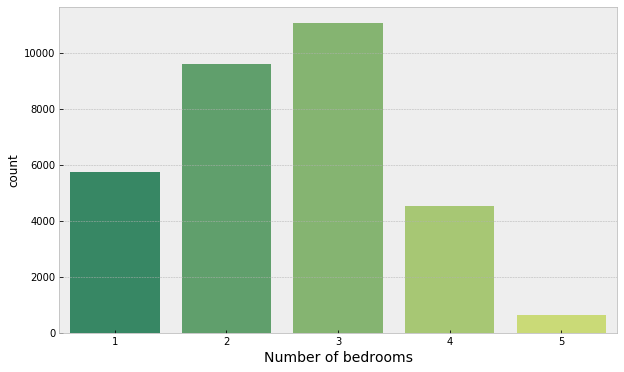


Category with minimum number of bedrooms: 1
Category with maximum number of bedrooms: 5

Number of rows contained in other bedrooms categories: 245
% of rows contained in other bedrooms categories: 0.77 

% of rows contained in bedroom categories that compose at least 10% of data: 97.19
% of rows contained in bedroom categories that compose at least 5% of data: 97.19
% of rows contained in bedroom categories that compose at least 1% of data: 99.23


In [6]:
analyze_categorical_variable('bedrooms')

## Number of bathrooms

Number of properties in dataset that have 0 bathrooms: 142
% of properties in dataset that have 0 bathrooms: 0.45

bathrooms categories composed of at least 0.5% of total data 
-------------------------------------------------------
   bathrooms  count  % of total data  cum sum %
0          2  12372            38.82      38.82
1          1   9365            29.39      68.21
2          3   6309            19.80      88.01
3          4   2864             8.99      97.00
4          5    628             1.97      98.97


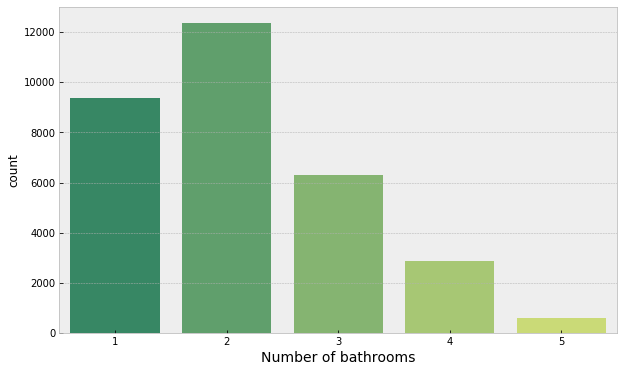


Category with minimum number of bathrooms: 1
Category with maximum number of bathrooms: 5

Number of rows contained in other bathrooms categories: 331
% of rows contained in other bathrooms categories: 1.04 

% of rows contained in bedroom categories that compose at least 10% of data: 88.01
% of rows contained in bedroom categories that compose at least 5% of data: 97.0
% of rows contained in bedroom categories that compose at least 1% of data: 98.97


In [7]:
analyze_categorical_variable('bathrooms')

## Create bed_bath_config feature

In [8]:
def analyze_bed_bath_config(feature='bed_bath_config', bound=0.2):
    
    count_df = pd.DataFrame(df[feature].value_counts())
    percent_df = round(df[feature].value_counts(normalize=True) * 100, 2)
    count_percent_df = pd.concat([count_df, percent_df], axis=1).reset_index()
    count_percent_df.columns = [feature, 'count', '% of total data']
    count_percent_df['cum sum %'] = count_percent_df['% of total data'].cumsum()
    
    selected_categories = percent_df[percent_df >= bound].index.tolist()
    selected_data = count_percent_df[count_percent_df[feature].isin(selected_categories)]
    
    print('\n{} categories composed of at least {}% of total data'.format(feature, bound), '\n' + '-'*55)
    print(selected_data)
    
    # Bar plot
    x = selected_data[feature]
    y = selected_data['count']

    plt.figure(figsize=(15,6))
    sb.barplot(x=x, y=y, palette='summer')
    plt.xlabel('Number of {}'.format(feature), size=14)
    plt.show()
    
    print("\nCategory with minimum number of {}:".format(feature), 
          min(selected_categories))
    print("Category with maximum number of {}:".format(feature), 
          max(selected_categories))

    others_count = len(df[df[feature].isin(selected_categories)==False])
    print("\nNumber of rows contained in other {} categories:".format(feature), 
          others_count)
    print("% of rows contained in other {} categories:".format(feature), 
          round(others_count / len(df) * 100, 2), 
          '\n')

    for num in [10, 5, 1]:
        print("% of rows contained in bedroom categories that compose at least {}% of data:".format(num), 
              round(selected_data[selected_data['% of total data'] >= num]['% of total data'].sum(), 2))


bed_bath_config categories composed of at least 0.2% of total data 
-------------------------------------------------------
   bed_bath_config  count  % of total data  cum sum %
0            2 - 2   6520            20.46      20.46
1            1 - 1   5561            17.45      37.91
2            3 - 2   5367            16.84      54.75
3            3 - 3   3697            11.60      66.35
4            2 - 1   2640             8.28      74.63
5            4 - 3   2136             6.70      81.33
6            4 - 4   1746             5.48      86.81
7            3 - 1   1081             3.39      90.20
8            3 - 4    807             2.53      92.73
9            2 - 3    383             1.20      93.93
10           4 - 2    292             0.92      94.85
11           4 - 5    287             0.90      95.75
12           5 - 4    256             0.80      96.55
13           5 - 5    216             0.68      97.23
14           1 - 2    167             0.52      97.75
15         

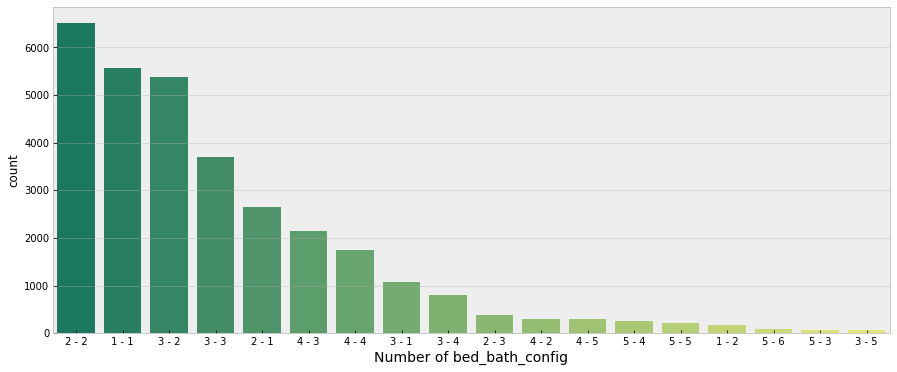


Category with minimum number of bed_bath_config: 1 - 1
Category with maximum number of bed_bath_config: 5 - 6

Number of rows contained in other bed_bath_config categories: 494
% of rows contained in other bed_bath_config categories: 1.55 

% of rows contained in bedroom categories that compose at least 10% of data: 66.35
% of rows contained in bedroom categories that compose at least 5% of data: 86.81
% of rows contained in bedroom categories that compose at least 1% of data: 93.93


In [9]:
df['bed_bath_config'] = df['bedrooms'].astype('str') + ' - ' + df['bathrooms'].astype('str')

analyze_bed_bath_config()

## Comuna

In [10]:
def analyze_comuna_feature():
    data = df['comuna'].value_counts()

    plt.figure(figsize=(18,7))
    sb.barplot(x=data.index, y=data.values, palette='plasma')
    plt.title('Count of properties per comuna', size=14)
    plt.xticks(rotation=45, ha='right')
    plt.show()

    print('Number of distinct comunas in the dataset:', len(df['comuna'].unique()))
    print('Number of null values for comuna field:', df['comuna'].isnull().sum())

    count_df = pd.DataFrame(df['comuna'].value_counts())
    percent_df = pd.DataFrame(round(df['comuna'].value_counts(normalize=True) * 100, 2))
    count_percent_df = pd.concat([count_df, percent_df], axis=1)
    count_percent_df.columns = ['count', '% of total data']
    count_percent_df['cum sum %'] = count_percent_df['% of total data'].cumsum()

    n = 15
    print('\nTop {} comunas with more properties'.format(n), '\n' + '-'*50)
    print(count_percent_df.head(n))
    print('\nTop {} comunas with less properties'.format(n), '\n' + '-'*40)
    print(count_percent_df[['count', '% of total data']].sort_values(by='count').head(n))

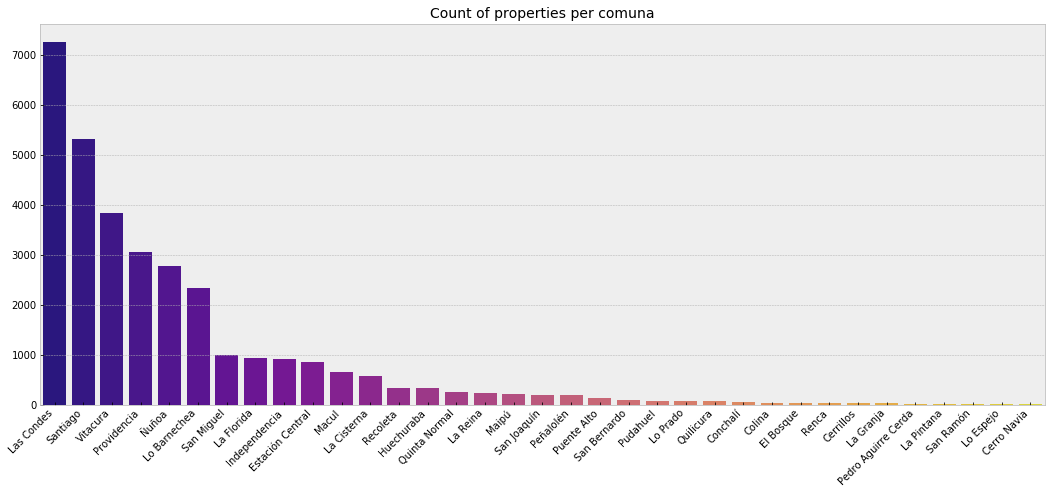

Number of distinct comunas in the dataset: 35
Number of null values for comuna field: 0

Top 15 comunas with more properties 
--------------------------------------------------
                  count  % of total data  cum sum %
Las Condes         7249            22.75      22.75
Santiago           5302            16.64      39.39
Vitacura           3838            12.04      51.43
Providencia        3052             9.58      61.01
Ñuñoa              2765             8.68      69.69
Lo Barnechea       2328             7.30      76.99
San Miguel         1000             3.14      80.13
La Florida          926             2.91      83.04
Independencia       913             2.86      85.90
Estación Central    852             2.67      88.57
Macul               656             2.06      90.63
La Cisterna         569             1.79      92.42
Recoleta            332             1.04      93.46
Huechuraba          325             1.02      94.48
Quinta Normal       243             0.76   

In [11]:
analyze_comuna_feature()

## Neighborhood

In [12]:
def analyze_neighborhood_feature():
    
    data = df.copy()
    neighbor_regex = '[\w\-\s]+'

    neighborhood_set = set()
    for idx, row in data.iterrows():
        if bool(re.match(neighbor_regex, data.loc[idx, 'neighborhood'])):
            data.loc[idx, 'neighborhood'] = data.loc[idx, 'neighborhood'] + ' -- ' + data.loc[idx, 'comuna']
            neighborhood_set.add(data.loc[idx, 'neighborhood'])

    neighborhood_list = list(neighborhood_set)
    neighborhood_series = data[data['neighborhood'].isin(neighborhood_list)]['neighborhood']

    print('Number of distinct neighborhoods in the dataset:', len(neighborhood_list))
    print('\nNumber of null values for neighborhood field:', data['neighborhood'].isnull().sum())
    print('% of null values for neighborhood field:', data['neighborhood'].isnull().sum() / len(data))

    regex_match = lambda x: bool(re.match(neighbor_regex, x))
    bool_series = data['neighborhood'].apply(regex_match)

    print('\nNumber of rows with non-valid values for neighborhood field:', 
          len(bool_series[bool_series==False]))
    print('% of rows with non-valid values for neighborhood field:', 
          round((len(bool_series[bool_series==False]) / len(data)) * 100, 2))
    print('List of non-valid values:', data[bool_series==False]['neighborhood'].unique().tolist())

    count_df = pd.DataFrame(neighborhood_series.value_counts())
    percent_df = pd.DataFrame(round(neighborhood_series.value_counts(normalize=True) * 100, 2))
    count_percent_df = pd.concat([count_df, percent_df], axis=1)
    count_percent_df.columns = ['count', '% of total data']
    count_percent_df['cum sum %'] = count_percent_df['% of total data'].cumsum()
    
    n = 20
    print('\nTop {} neighborhoods with more properties'.format(n), '\n' + '-'*40)
    print(count_percent_df.head(n))
    
    # Bar plot
    x = count_percent_df.head(n).index
    y = count_percent_df.head(n)['count']
    
    plt.figure(figsize=(15,6))
    sb.barplot(x=x, y=y, palette='plasma')
    plt.title('Count of properties for top {} neighborhoods'.format(n), size=14)
    plt.xticks(rotation=45, ha='right')
    plt.show()

    for num in [1, 0.5]:
        num_df = count_percent_df[count_percent_df['% of total data']>=num]
        print('\n% of rows contained in neighborhood categories that contain at least {}% of data:'.format(num), 
              round(num_df['% of total data'].sum(), 2))
        print('Number of neighborhood categories that contain at least {}% of data:'.format(num), 
              len(num_df))

Number of distinct neighborhoods in the dataset: 265

Number of null values for neighborhood field: 0
% of null values for neighborhood field: 0.0

Number of rows with non-valid values for neighborhood field: 1295
% of rows with non-valid values for neighborhood field: 4.06
List of non-valid values: ['']

Top 20 neighborhoods with more properties 
----------------------------------------
                                           count  % of total data  cum sum %
La Dehesa -- Lo Barnechea                   1392             4.55       4.55
Centro Histórico De Santiago -- Santiago    1346             4.40       8.95
Barrio El Golf -- Las Condes                1275             4.17      13.12
Parque Bicentenario -- Vitacura             1101             3.60      16.72
Santa Isabel -- Santiago                     970             3.17      19.89
Las Lilas -- Providencia                     712             2.33      22.22
Los Leones -- Providencia                    637             2.08     

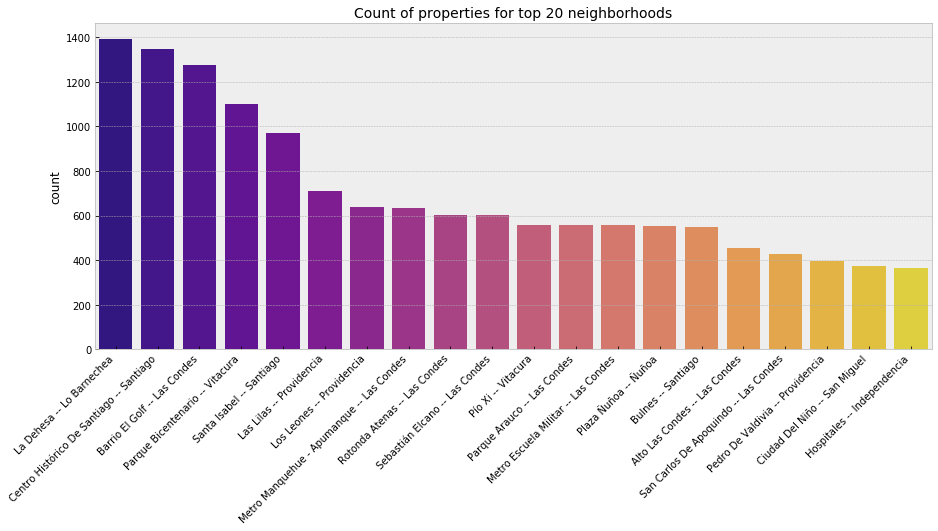


% of rows contained in neighborhood categories that contain at least 1% of data: 53.63
Number of neighborhood categories that contain at least 1% of data: 27

% of rows contained in neighborhood categories that contain at least 0.5% of data: 80.3
Number of neighborhood categories that contain at least 0.5% of data: 63


In [13]:
analyze_neighborhood_feature()

# Analyzing continuous variables

## Latitude / Longitude

In [14]:
coord_regex = '^-?\d+\.\d+$'
lat_bool = df['latitude'].apply(lambda x: bool(re.match(coord_regex, str(x))))
long_bool = df['longitude'].apply(lambda x: bool(re.match(coord_regex, str(x))))

print('Number of rows with non-valid values for latitude field:', 
      len(df[lat_bool==False]))
print('% of rows with non-valid values for latitude field:', 
      round((len(df[lat_bool==False]) / len(df)) * 100, 2))

print('\nNumber of rows with non-valid values for longitude field:', 
      len(df[lat_bool==False]))
print('% of rows with non-valid values for longitude field:', 
      round((len(df[lat_bool==False]) / len(df)) * 100, 2))

Number of rows with non-valid values for latitude field: 1
% of rows with non-valid values for latitude field: 0.0

Number of rows with non-valid values for longitude field: 1
% of rows with non-valid values for longitude field: 0.0


## Analyzing area and price variables

In [15]:
def analyze_continuous_variable(feature):
    # Null values analysis
    null_values_sum = df[feature].isnull().sum()
    print("Number of rows that contain null values for {} field:".format(feature), 
          null_values_sum)
    print("% of rows that contain null values for {} field:".format(feature), 
          round((null_values_sum / len(df)) * 100, 2))

    # Zero values analysis
    zero_values_sum = len(df[df[feature]==0])
    print("\nNumber of rows with {} equal to zero:".format(feature), 
          zero_values_sum)
    print("% of rows with {} equal to zero:".format(feature), 
          round((zero_values_sum / len(df)) * 100, 2), '\n')

    # Outliers analysis using robust statistics

    # Exclude rows with values equal to zero for the analyzed feature
    data = df[df[feature]!=0][feature]

    critical_values = [0.1, 0.25, 0.5, 1] 

    print('Minimum value --- {:,}'.format(data.min()))

    for num in critical_values:
        print('Percentile {} --- {:,}'.format(num, round(data.quantile(num / 100), 2)))
    
    print('*' * 25)
    for num in [25, 50, 75]:
        print('Percentile {} --- {:,}'.format(num, round(data.quantile(num / 100), 2)))
    print('*' * 25)

    for num in critical_values[::-1]:
        print('Percentile {} --- {:,}'.format(100 - num, round(data.quantile(1 - (num / 100)), 2)))

    print('Maximum value --- {:,}'.format(data.max()), '\n')

    print('Interquantile range value: {:,}'.format(round(data.quantile(0.75) - data.quantile(0.25), 2)), '\n')

    fig, axes = plt.subplots(2, 2, figsize=(12, 7))
    for ax, num in zip(axes.flatten(), critical_values):
        ax.set_title('Data between percentiles {} and {}'.format(num, 100 - num))
        sb.boxplot(data[(data > data.quantile(num / 100)) & ((data < data.quantile(1 - (num / 100))))], ax=ax)
    
    fig.tight_layout()

## covered_area_m2

Number of rows that contain null values for covered_area_m2 field: 0
% of rows that contain null values for covered_area_m2 field: 0.0

Number of rows with covered_area_m2 equal to zero: 183
% of rows with covered_area_m2 equal to zero: 0.57 

Minimum value --- 1.0
Percentile 0.1 --- 15.69
Percentile 0.25 --- 20.0
Percentile 0.5 --- 22.0
Percentile 1 --- 24.09
*************************
Percentile 25 --- 49.55
Percentile 50 --- 77.0
Percentile 75 --- 131.0
*************************
Percentile 99 --- 400.0
Percentile 99.5 --- 500.0
Percentile 99.75 --- 592.09
Percentile 99.9 --- 808.15
Maximum value --- 999,999,999,999,999.0 

Interquantile range value: 81.45 



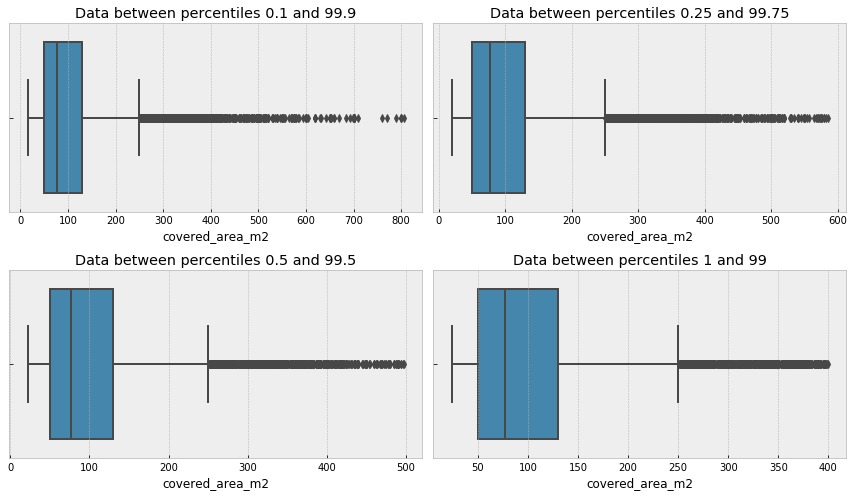

In [16]:
analyze_continuous_variable('covered_area_m2')

## total_area_m2

Number of rows that contain null values for total_area_m2 field: 0
% of rows that contain null values for total_area_m2 field: 0.0

Number of rows with total_area_m2 equal to zero: 1918
% of rows with total_area_m2 equal to zero: 6.02 

Minimum value --- 1.0
Percentile 0.1 --- 4.0
Percentile 0.25 --- 18.0
Percentile 0.5 --- 21.01
Percentile 1 --- 24.0
*************************
Percentile 25 --- 52.0
Percentile 50 --- 85.0
Percentile 75 --- 150.0
*************************
Percentile 99 --- 550.0
Percentile 99.5 --- 693.19
Percentile 99.75 --- 871.5
Percentile 99.9 --- 1,502.5
Maximum value --- 1e+16 

Interquantile range value: 98.0 



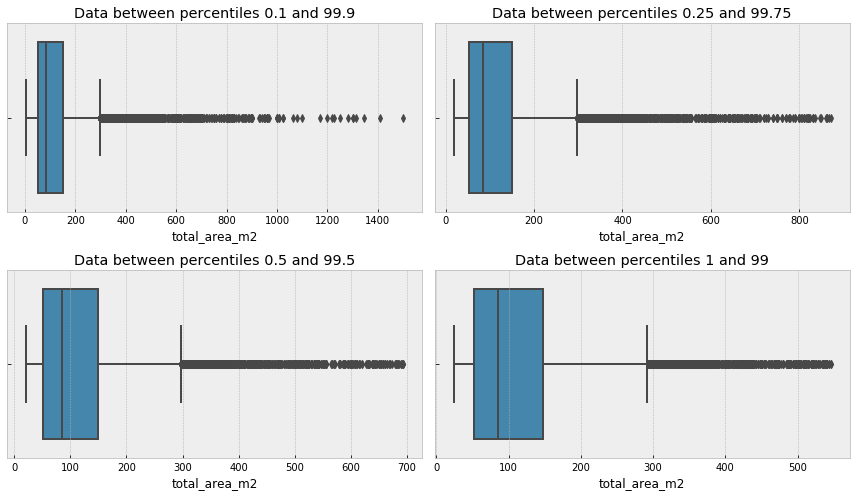

In [17]:
analyze_continuous_variable('total_area_m2')

## covered_area_m2 vs. total_area_m2

In [18]:
# Validate if there are rows where covered_area_m2 is greater than total_area_m2
non_valid_sum = len(df[df['covered_area_m2'] > df['total_area_m2']])

print('Number of rows where covered_area_m2 is greater than total_area_m2:', non_valid_sum)
print('% of rows where covered_area_m2 is greater than total_area_m2:', round((non_valid_sum / len(df)) * 100, 2))

Number of rows where covered_area_m2 is greater than total_area_m2: 2050
% of rows where covered_area_m2 is greater than total_area_m2: 6.43


## Price

In [19]:
# Transform all prices to UF values (for properties on sale)
for idx,row in df.iterrows():
    if (df.loc[idx, 'currency']=='CLP'):
        df.loc[idx, 'price'] = round(df.loc[idx, 'price'] / UF_VALUE, 2)
        df.loc[idx, 'currency'] = 'CLF'
    elif (df.loc[idx, 'currency']=='USD'):
        df.loc[idx, 'price'] = round((df.loc[idx, 'price'] * USD_VALUE) / UF_VALUE, 2)
        df.loc[idx, 'currency'] = 'CLF'

Number of rows that contain null values for price field: 0
% of rows that contain null values for price field: 0.0

Number of rows with price equal to zero: 0
% of rows with price equal to zero: 0.0 

Minimum value --- 0.06
Percentile 0.1 --- 16.76
Percentile 0.25 --- 733.52
Percentile 0.5 --- 1,046.7
Percentile 1 --- 1,329.08
*************************
Percentile 25 --- 3,050.0
Percentile 50 --- 6,150.0
Percentile 75 --- 11,500.0
*************************
Percentile 99 --- 39,000.0
Percentile 99.5 --- 49,330.0
Percentile 99.75 --- 59,000.0
Percentile 99.9 --- 66,000.0
Maximum value --- 196,793.0 

Interquantile range value: 8,450.0 



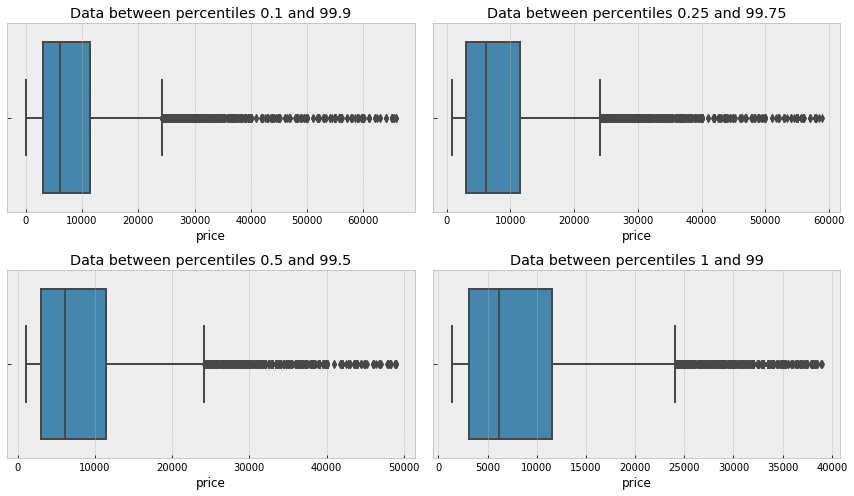

In [20]:
analyze_continuous_variable('price')